In [ ]:
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from hiv_patient import HIVPatient
from sklearn.ensemble import ExtraTreesRegressor 
import time

In [ ]:
patient = HIVPatient(clipping=False,logscale=False)

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # capacity of the buffer
        self.data = np.zeros((capacity, 14))
        self.index = 0 # index of the next cell to be filled
        self.unfilled_index = 0 # index of the first line of 0

    def append(self, s, a, r, s_):
        self.data[self.index, :6] = s
        self.data[self.index, 6:7] = a
        self.data[self.index, 7:8] = r
        self.data[self.index, 8:] = s_
        self.index = (self.index + 1) % self.capacity
        if self.unfilled_index!=self.capacity:
            self.unfilled_index += 1

    def sample(self, batch_size):
        idx = np.random.randint(0,self.unfilled_index,size=min(batch_size, self.unfilled_index))
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [87]:
class FittedQN_agent:
    def __init__(self, config):
        self.gamma = config['gamma']
        self.batch_size = config['batch_size']
        self.nb_actions = config['nb_actions']
        self.memory = ReplayBuffer(config['buffer_size'])
        self.epsilon_max = config['epsilon_max']
        self.epsilon_min = config['epsilon_min']
        self.epsilon_stop = config['epsilon_decay_period']
        self.epsilon_delay = config['epsilon_delay_decay']
        self.epsilon_step = (self.epsilon_max-self.epsilon_min)/self.epsilon_stop
        self.total_steps = 0
        self.dur = config['duration']
        self.model = ExtraTreesRegressor(n_estimators = 0, warm_start=True)

    def train(self, env, max_episode):
        episode_return = []
        episode = 0
        episode_cum_reward = 0
        s = env.reset()
        epsilon = self.epsilon_max
        step = 0
        while episode < max_episode:
            start = time.time()
            # update epsilon
            if step > self.epsilon_delay:
                epsilon = max(self.epsilon_min, epsilon-self.epsilon_step)

            # select epsilon-greedy action
            if np.random.rand() < epsilon:
                action = np.random.randint(self.nb_actions)
            else:
                action = np.argmax([self.model.predict(np.append(s,a).reshape(1,-1)) for a in range(self.nb_actions)])

            # step
            next_s, reward, _, _ = env.step(action)
            self.memory.append(s, action, reward, next_s)
            episode_cum_reward += reward

            # train
            if self.memory.unfilled_index > self.batch_size:
                mini_batch = self.memory.sample(self.batch_size)
                X, A, R, Y = mini_batch[:,:6], mini_batch[:,6:7], mini_batch[:,7:8], mini_batch[:,8:]
                self.model.n_estimators += 1
                if self.model.n_estimators == 1:
                    self.model.fit(np.concatenate((X,A), axis=1), R.ravel())
                else:
                    self.model.fit(np.concatenate((X,A), axis=1), (R + self.gamma * np.max([self.model.predict(np.concatenate((Y, np.ones((len(Y),1))*a),axis=1)) for a in range(self.nb_actions)])).ravel())

            # next transition
            step += 1
            if step%self.dur==0:
                episode += 1
                print("Episode ", '{:3d}'.format(episode), 
                      ", epsilon ", '{:6.2f}'.format(epsilon), 
                      ", buffer size ", '{:5d}'.format(len(self.memory)), 
                      ", episode return ", '{:4.1f}'.format(episode_cum_reward),
                      ", durée {:4.1} s".format(time.time()-start),
                      sep='')
                s = env.reset()
                episode_return.append(episode_cum_reward)
                episode_cum_reward = 0
                start = time.time()
            else:
                s = next_s

        return episode_return

Episode   1, epsilon   1.00, buffer size  1000, episode return 815703.1, durée  0.1 s
Episode   2, epsilon   1.00, buffer size  1000, episode return 554315.6, durée 0.08 s
Episode   3, epsilon   1.00, buffer size  1000, episode return 540153.8, durée 0.09 s
Episode   4, epsilon   1.00, buffer size  1000, episode return 470504.6, durée 0.09 s
Episode   5, epsilon   1.00, buffer size  1000, episode return 534903.8, durée 0.08 s
Episode   6, epsilon   0.99, buffer size  1000, episode return 760375.8, durée 0.07 s
Episode   7, epsilon   0.99, buffer size  1000, episode return 562155.0, durée 0.08 s
Episode   8, epsilon   0.99, buffer size  1000, episode return 524980.8, durée 0.09 s
Episode   9, epsilon   0.99, buffer size  1000, episode return 844380.9, durée  0.1 s
Episode  10, epsilon   0.99, buffer size  1000, episode return 819661.9, durée 0.09 s
Episode  11, epsilon   0.98, buffer size  1000, episode return 944166.2, durée  0.1 s
Episode  12, epsilon   0.98, buffer size  1000, episod

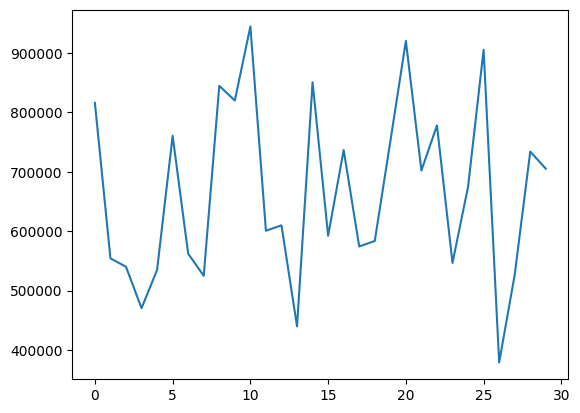

In [88]:
config = {'observation_space': 6,
          'nb_actions': 4,
          'gamma': 0.95,
          'buffer_size': 1000,
          'epsilon_min': 0.01,
          'epsilon_max': 1.,
          'epsilon_decay_period': 10000,
          'epsilon_delay_decay': 50,
          'batch_size': 3,
          'duration':20}

agent = FittedQN_agent(config)
scores = agent.train(patient, max_episode=30)
plt.plot(scores)